# Import packages

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys, sys
from pathlib import Path
for p in [Path.cwd()] + list(Path.cwd().parents):
    if p.name == 'Multifirefly-Project':
        os.chdir(p)
        sys.path.insert(0, str(p / 'multiff_analysis/multiff_code/methods'))
        break
    
from data_wrangling import specific_utils, process_monkey_information, general_utils
from pattern_discovery import pattern_by_trials, pattern_by_trials, cluster_analysis, organize_patterns_and_features
from visualization.matplotlib_tools import plot_behaviors_utils
from neural_data_analysis.neural_analysis_tools.get_neural_data import neural_data_processing
from neural_data_analysis.neural_analysis_tools.visualize_neural_data import plot_neural_data, plot_modeling_result
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars
from neural_data_analysis.topic_based_neural_analysis.neural_vs_behavioral import prep_monkey_data, prep_target_data, neural_vs_behavioral_class
from neural_data_analysis.topic_based_neural_analysis.planning_and_neural import planning_and_neural_class, pn_utils, pn_helper_class, pn_aligned_by_seg
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class
from neural_data_analysis.neural_analysis_tools.cca_methods import cca_class, cca_utils, cca_cv_utils
from neural_data_analysis.neural_analysis_tools.cca_methods.cca_plotting import cca_plotting, cca_plot_lag_vs_no_lag, cca_plot_cv
from machine_learning.ml_methods import regression_utils, regz_regression_utils, ml_methods_class, classification_utils, ml_plotting_utils, ml_methods_utils
from planning_analysis.show_planning import nxt_ff_utils, show_planning_utils
from neural_data_analysis.neural_analysis_tools.align_trials import time_resolved_regression, plot_time_resolved_regression
from neural_data_analysis.neural_analysis_tools.gpfa_methods import elephant_utils, fit_gpfa_utils, plot_gpfa_utils, gpfa_helper_class

import sys
import math
import gc
import subprocess
from pathlib import Path
from importlib import reload

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from scipy import linalg, interpolate
from scipy.signal import fftconvolve
from scipy.io import loadmat
from scipy import sparse
import torch
from numpy import pi

# Machine Learning imports
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.multivariate.cancorr import CanCorr

# Neuroscience specific imports
import neo
import rcca
import quantities as pq

plt.rcParams["animation.html"] = "html5"
os.environ['KMP_DUPLICATE_LIB_OK']='True'
rc('animation', html='jshtml')
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['animation.embed_limit'] = 2**128
pd.set_option('display.float_format', lambda x: '%.5f' % x)
np.set_printoptions(suppress=True)
print("done")

%load_ext autoreload
%autoreload 2

done
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# retrieve data

In [2]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Bruno/data_0330"

In [3]:
raw_data_folder_path = "all_monkey_data/raw_monkey_data/monkey_Schro/data_0416"

In [ ]:
reduce_y_var_lags = False
planning_data_by_point_exists_ok = True
y_data_exists_ok = True

pn = pn_aligned_by_seg.PlanningAndNeuralSegmentAligned(raw_data_folder_path=raw_data_folder_path)
pn.prep_data_to_analyze_planning(planning_data_by_point_exists_ok=planning_data_by_point_exists_ok)
pn.planning_data_by_point, cols_to_drop = general_utils.drop_columns_with_many_nans(
    pn.planning_data_by_point)
pn.get_x_and_y_data_for_modeling(exists_ok=y_data_exists_ok, reduce_y_var_lags=reduce_y_var_lags)

Loaded binned_spikes_df from all_monkey_data/processed_neural_data/monkey_Schro/data_0416/binned_spikes_df_0p1.csv
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/planning_data_by_point/opt_arc_stop_closest/test/cur_vis_0_1_window_-50cm_0cm
Loaded planning_data_by_point from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/planning_data_by_point/opt_arc_stop_closest/control/cur_vis_0_1_window_-50cm_0cm
Overlap: []
Percentage overlap relative to df1: 0.00%
Percentage overlap relative to df2: 0.00%
Average percentage overlap: 0.00%
Loaded behav_data_by_bin from all_monkey_data/target_decoder/monkey_Schro/data_0416/behav_data_by_point.csv
Retrieved monkey_information
The number of points that were removed due to delta_position exceeding the ceiling is 0
There are 1 duplicated point_index in bin_info. Note: one_point_index_per_bin is False
0.2% of rows are dropped in planning_data_by_bin due to having missing values
binned_spikes_df.s

# get planning_data by segment

## get data and fit gpfa

In [31]:
pn.prepare_seg_aligned_data(segment_duration=2, rebinned_max_x_lag_number=2)

Dropped 20 columns due to containing NA in rebinned_y_var via calling drop_na_cols function: ['cur_cntr_arc_curv', 'cur_opt_arc_curv', 'nxt_cntr_arc_curv', 'nxt_opt_arc_curv', 'cur_opt_arc_end_heading', 'cur_cntr_arc_end_heading', 'angle_opt_arc_from_cur_end_to_nxt', 'angle_cntr_arc_from_cur_end_to_nxt', 'monkey_y_target_last_seen', 'd_heading_since_target_last_seen', 'cum_distance_when_target_last_seen', 'time_target_last_seen', 'target_last_seen_angle', 'cum_distance_since_target_last_seen', 'distance_from_monkey_pos_target_last_seen', 'time_since_target_last_seen', 'monkey_x_target_last_seen', 'target_last_seen_distance', 'monkey_angle_target_last_seen', 'target_last_seen_angle_to_boundary']


In [6]:
pn.get_gpfa_traj(latent_dimensionality=5)

Loaded GPFA trajectories from all_monkey_data/planning_and_neural/monkey_Schro/data_0416/seg_aligned/gpfa_trajectories/gpfa_neural_aligned_segEnd_bin0p1_d5.pkl


In [7]:
# for regression later
use_raw_spike_data_instead = False

pn.get_concat_data_for_regression(use_raw_spike_data_instead=False,
                                    use_lagged_raw_spike_data=False,
                                    apply_pca_on_raw_spike_data=False,
                                    num_pca_components=7)
pn.print_data_dimensions()


No NA values found in DataFrame

No NA values found in DataFrame

=== Data Dimensions Summary ===
Total number of trials: 126

Concatenated Data Shapes (total n_timepoints × n_features):
  concat_neural_trials:     (2520, 7)
  concat_behav_trials:      (2520, 98)


In [8]:
# example trajectories
for traj in pn.trajectories[:5]:
    print(traj.shape)

(5, 20)
(5, 20)
(5, 20)
(5, 20)
(5, 20)


## point-wise segment regression

In [9]:
pn.time_resolved_regression_cv()

Timepoints: 100%|██████████| 20/20 [00:24<00:00,  1.21s/it]


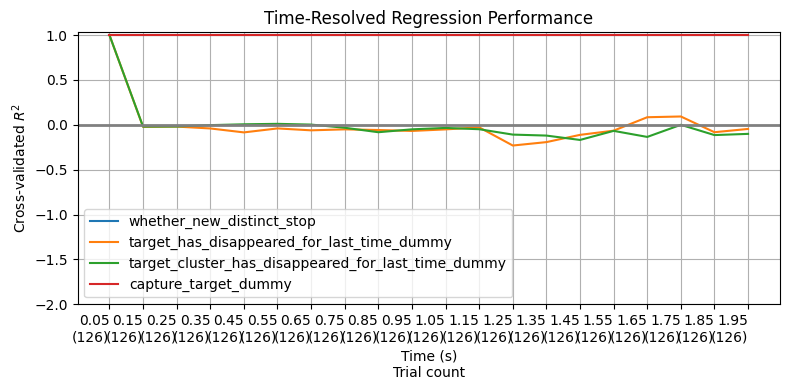

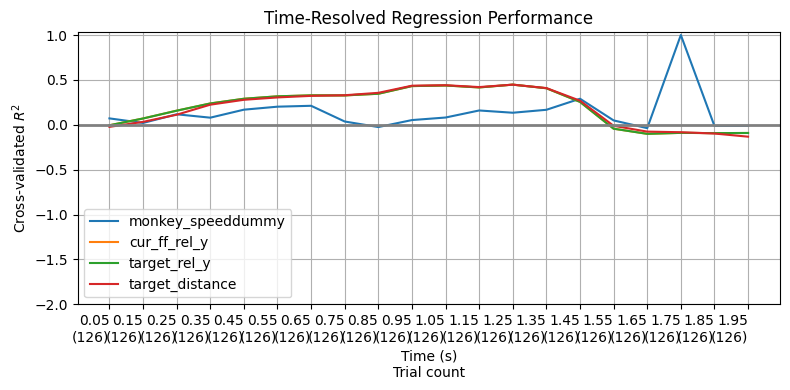

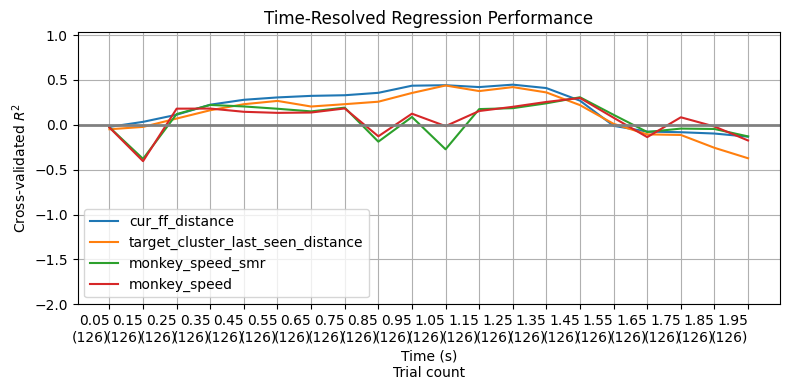

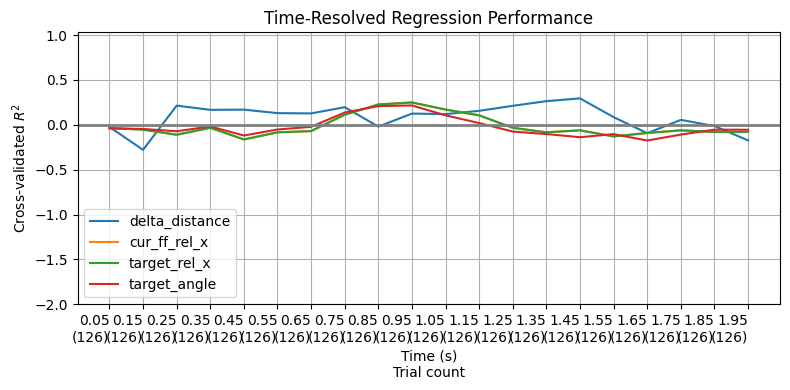

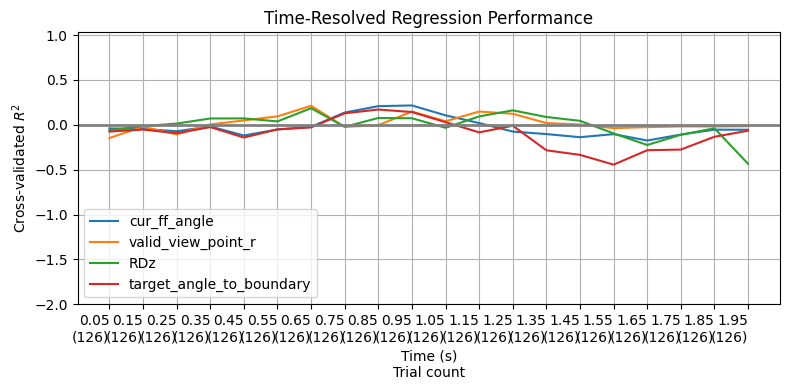

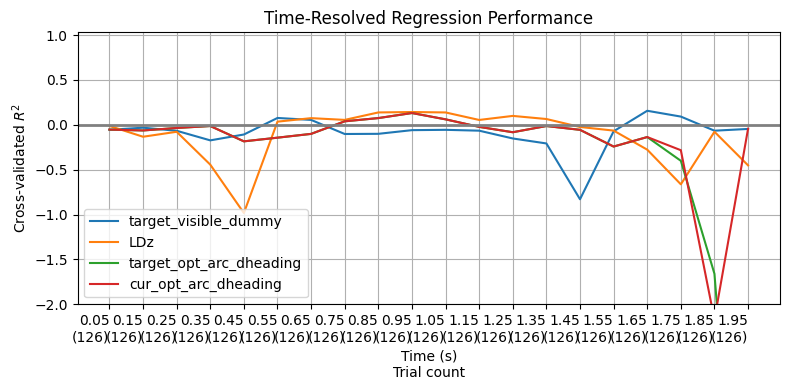

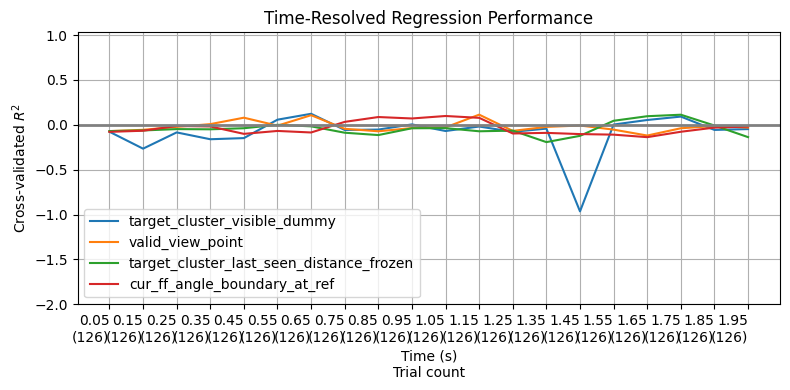

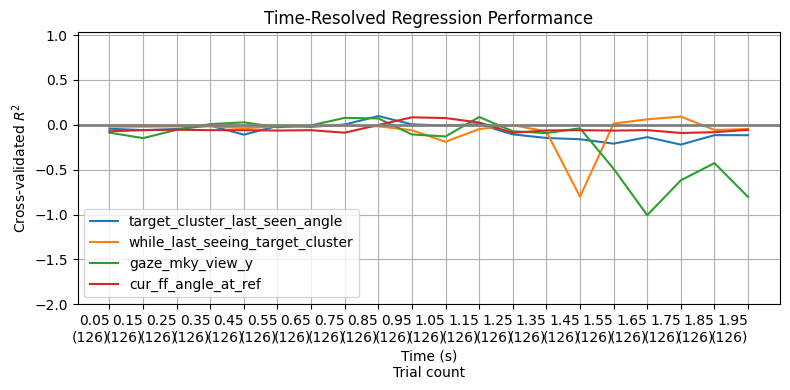

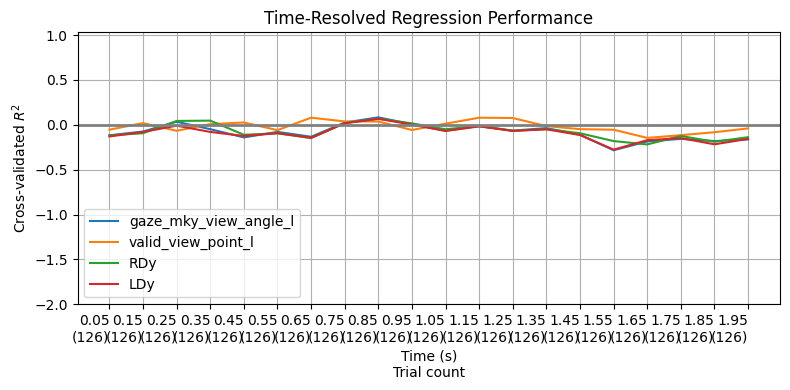

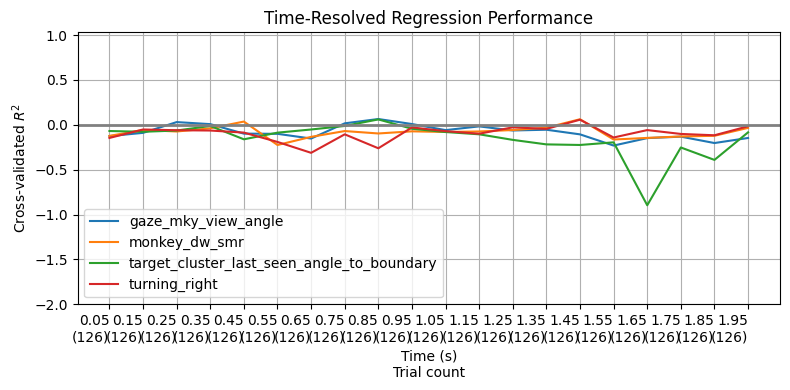

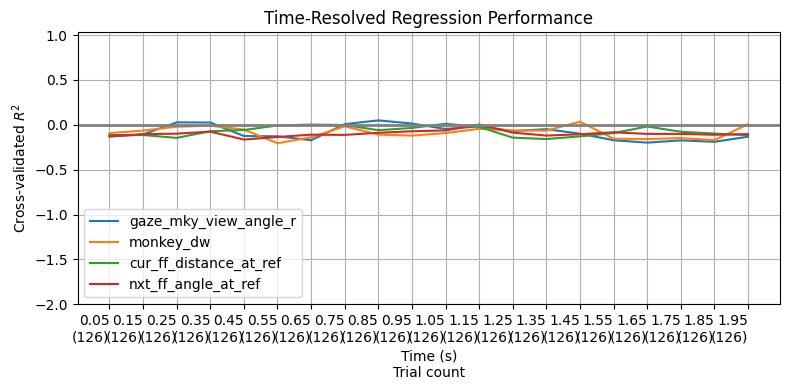

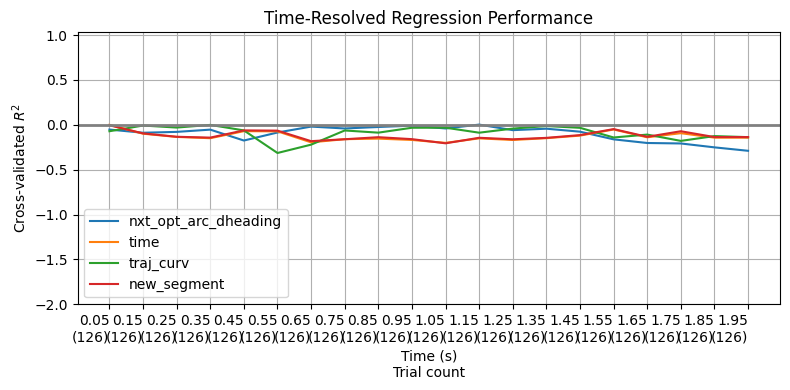

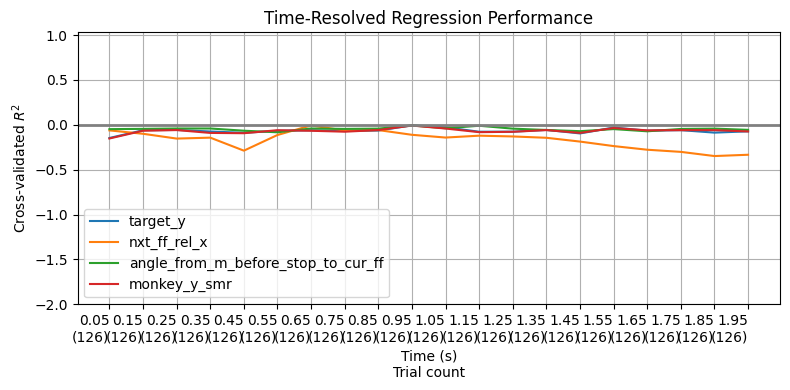

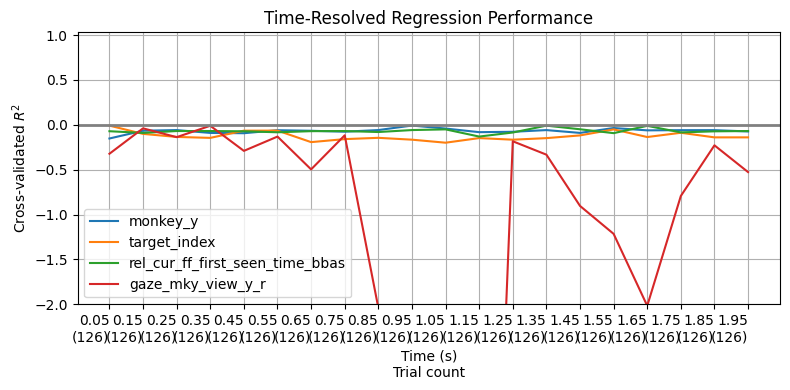

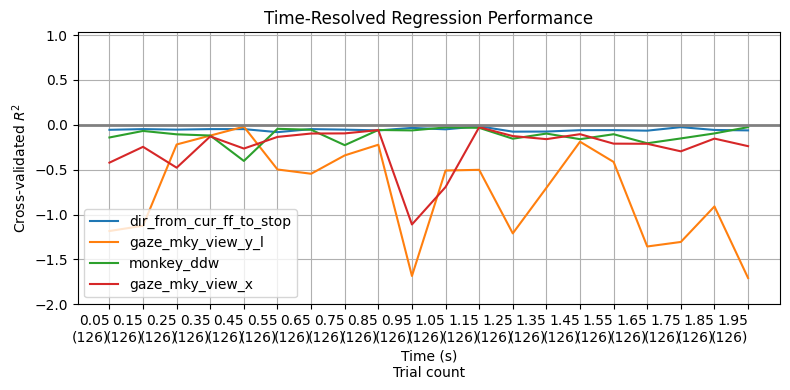

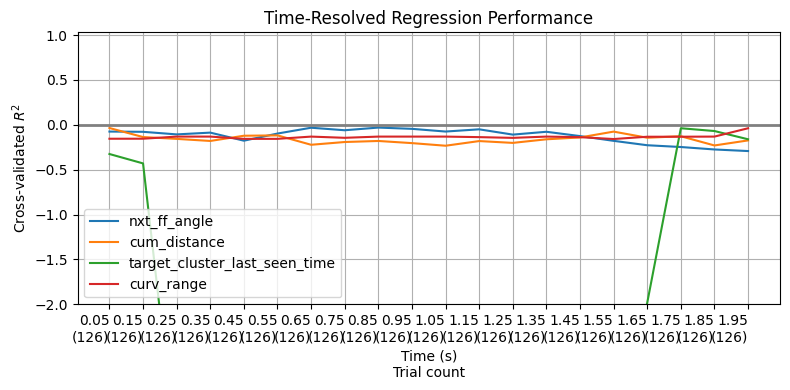

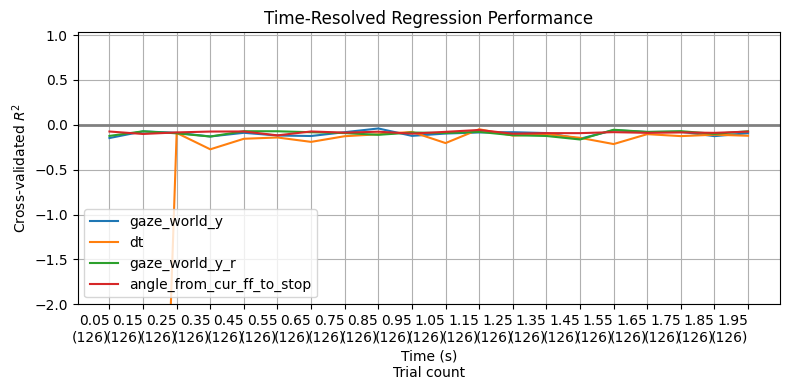

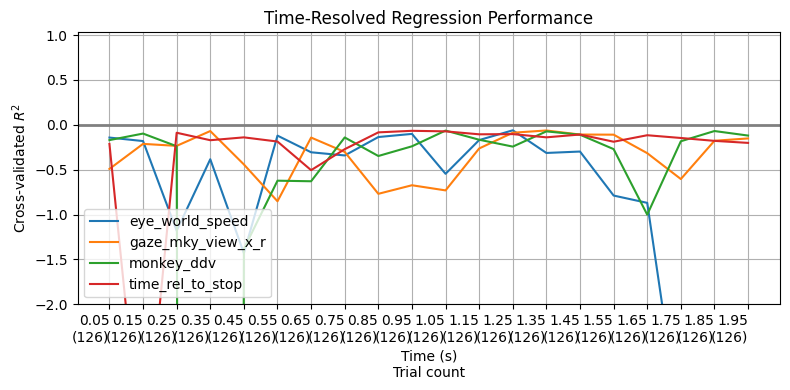

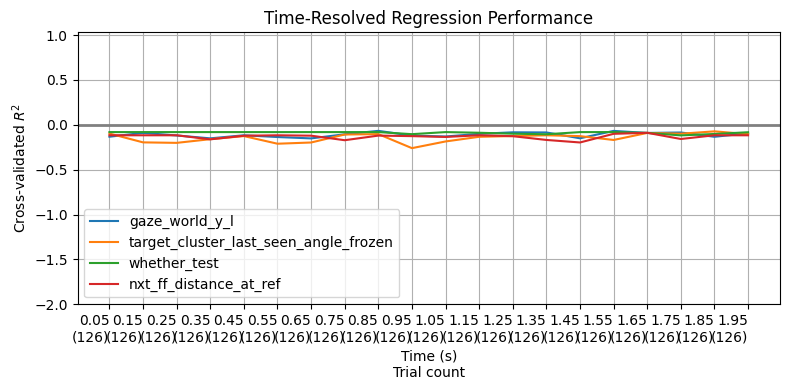

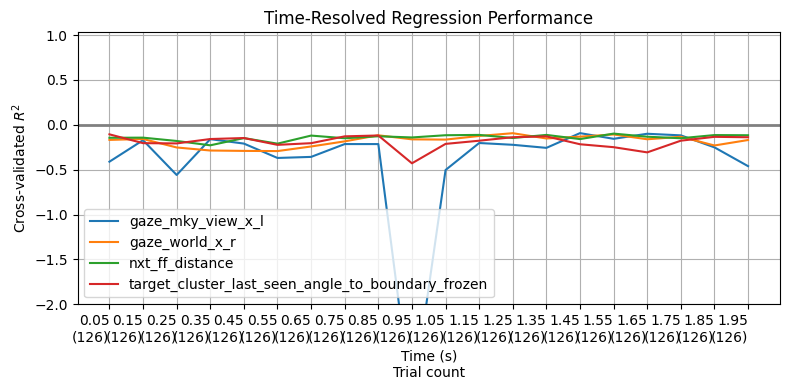

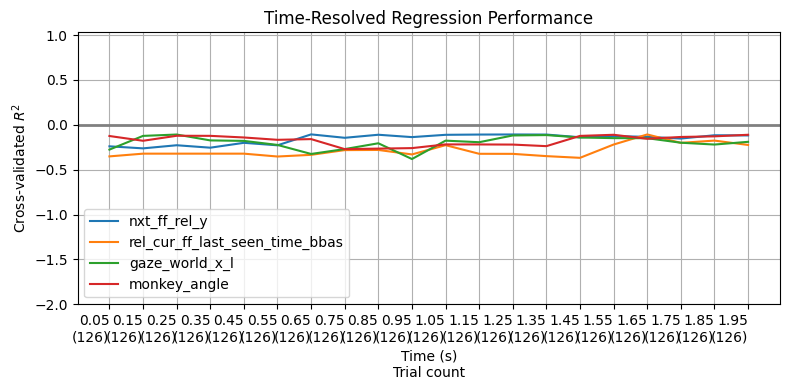

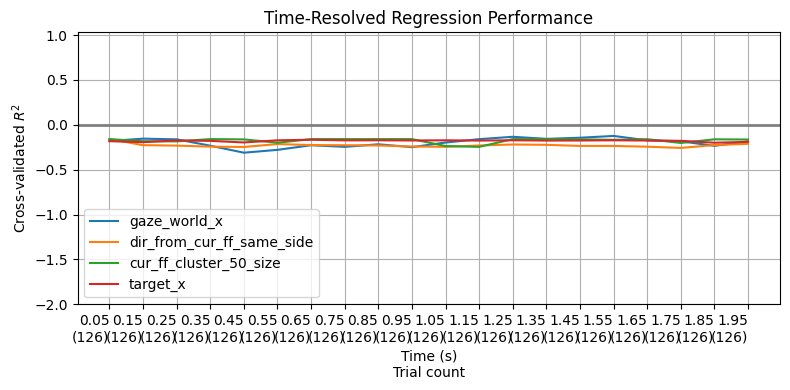

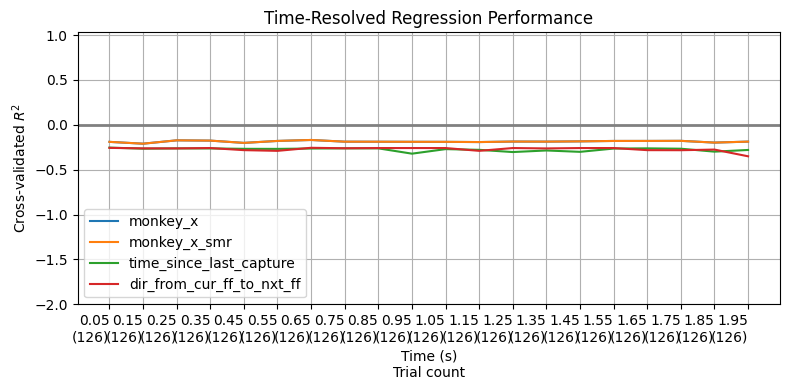

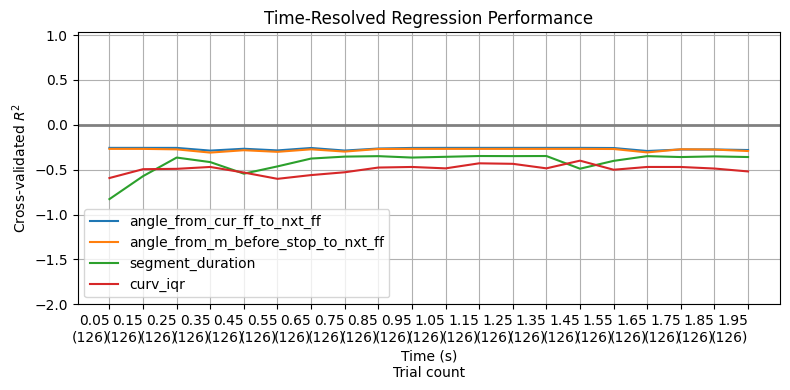

In [10]:
pn.plot_time_resolved_regression()

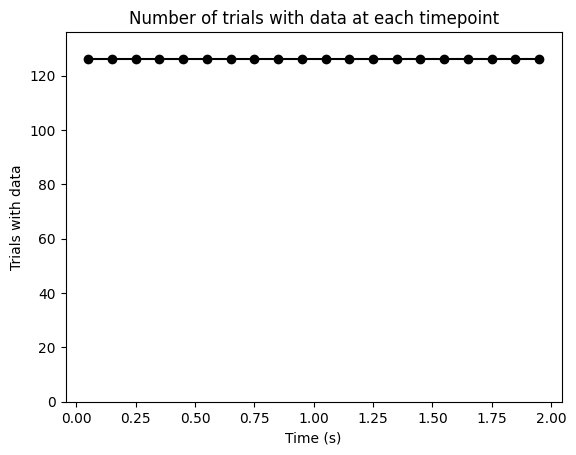

In [11]:
pn.plot_trial_counts_by_timepoint()  # 

## concat data regression

In [12]:
pn.separate_test_and_control_data()
print(pn.concat_neural_trials.shape)
print(pn.concat_behav_trials.shape)

(2520, 7)
(2520, 98)


In [13]:
general_utils.check_na_in_df(pn.concat_neural_trials)
general_utils.check_na_in_df(pn.concat_behav_trials)


No NA values found in DataFrame

No NA values found in DataFrame


(Empty DataFrame
 Columns: [new_segment, new_bin, cur_ff_distance, cur_opt_arc_dheading, segment_duration, nxt_ff_distance, nxt_opt_arc_dheading, nxt_ff_angle, time_rel_to_stop, cur_ff_angle, time, target_index, cur_ff_rel_x, cur_ff_rel_y, nxt_ff_rel_x, nxt_ff_rel_y, traj_curv, angle_from_m_before_stop_to_cur_ff, angle_from_m_before_stop_to_nxt_ff, dir_from_cur_ff_to_stop, dir_from_cur_ff_to_nxt_ff, dir_from_cur_ff_same_side, angle_from_cur_ff_to_stop, angle_from_cur_ff_to_nxt_ff, nxt_ff_distance_at_ref, nxt_ff_angle_at_ref, cur_ff_distance_at_ref, cur_ff_angle_at_ref, cur_ff_angle_boundary_at_ref, curv_range, curv_iqr, cur_ff_cluster_50_size, rel_cur_ff_last_seen_time_bbas, rel_cur_ff_first_seen_time_bbas, whether_test, monkey_angle, monkey_x, target_cluster_last_seen_angle_to_boundary_frozen, monkey_speeddummy, monkey_x_smr, monkey_ddv, gaze_mky_view_angle, target_cluster_visible_dummy, target_rel_x, monkey_y, gaze_world_y_l, turning_right, target_cluster_last_seen_angle_frozen, targ

In [14]:
# Multivariate linear regression
pn.y_var_lr_df = neural_data_modeling.get_y_var_lr_df(
                pn.concat_neural_trials, pn.concat_behav_trials)

/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid
/opt/miniconda3/envs/ff_venv2/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1871: RuntimeWarning: invalid value encountered in scalar divide
  return self.mse_model/self.mse_resid


In [15]:
# use_raw_spike_data_instead=True,
# use_lagged_raw_spike_data=True,
# apply_pca_on_raw_spike_data=True,
pn.y_var_lr_df

,feature,r,r_squared,p_values,significant
0,new_segment,1.00000,1.00000,0.00000,True
1,new_bin,1.00000,1.00000,0.00000,True
2,whether_new_distinct_stop,1.00000,1.00000,NaN,False
3,capture_target_dummy,1.00000,1.00000,NaN,False
4,new_seg_duration,1.00000,1.00000,1.00000,False
5,time_rel_to_stop,1.00000,1.00000,0.00000,True
6,target_index,0.99700,0.99400,0.00000,True
7,time,0.99562,0.99126,0.00000,True
8,cum_distance,0.98736,0.97488,0.00000,True
9,target_rel_y,0.90266,0.81479,0.00000,True


In [16]:
# use_raw_spike_data_instead = True
pn.y_var_lr_df.head(7)

,feature,r,r_squared,p_values,significant
0,new_segment,1.00000,1.00000,0.00000,True
1,new_bin,1.00000,1.00000,0.00000,True
2,whether_new_distinct_stop,1.00000,1.00000,NaN,False
3,capture_target_dummy,1.00000,1.00000,NaN,False
4,new_seg_duration,1.00000,1.00000,1.00000,False
5,time_rel_to_stop,1.00000,1.00000,0.00000,True
6,target_index,0.99700,0.99400,0.00000,True


In [17]:
# use_raw_spike_data_instead=True,
# use_lagged_raw_spike_data=True,

pn.y_var_lr_df.head(7)

,feature,r,r_squared,p_values,significant
0,new_segment,1.00000,1.00000,0.00000,True
1,new_bin,1.00000,1.00000,0.00000,True
2,whether_new_distinct_stop,1.00000,1.00000,NaN,False
3,capture_target_dummy,1.00000,1.00000,NaN,False
4,new_seg_duration,1.00000,1.00000,1.00000,False
5,time_rel_to_stop,1.00000,1.00000,0.00000,True
6,target_index,0.99700,0.99400,0.00000,True


In [18]:
# use_raw_spike_data_instead = False
pn.y_var_lr_df.head(20)

,feature,r,r_squared,p_values,significant
0,new_segment,1.00000,1.00000,0.00000,True
1,new_bin,1.00000,1.00000,0.00000,True
2,whether_new_distinct_stop,1.00000,1.00000,NaN,False
3,capture_target_dummy,1.00000,1.00000,NaN,False
4,new_seg_duration,1.00000,1.00000,1.00000,False
5,time_rel_to_stop,1.00000,1.00000,0.00000,True
6,target_index,0.99700,0.99400,0.00000,True
7,time,0.99562,0.99126,0.00000,True
8,cum_distance,0.98736,0.97488,0.00000,True
9,target_rel_y,0.90266,0.81479,0.00000,True


## segment split regress CV

In [19]:
reload(ml_methods_utils)

<module 'machine_learning.ml_methods.ml_methods_utils' from '/Users/dusiyi/Documents/Multifirefly-Project/multiff_analysis/multiff_code/methods/machine_learning/ml_methods/ml_methods_utils.py'>

In [20]:
columns_of_interest = ['whether_test', 'cur_ff_distance', 'cur_ff_angle', 'nxt_ff_distance', 'nxt_ff_rel_y', 'nxt_opt_arc_dheading', 'nxt_ff_rel_x', 'nxt_ff_angle', 'nxt_ff_angle_at_ref']

In [21]:
all_results = []
for test_or_control in ['test', 'control', 'both']:
    x_var, y_var = pn.get_concat_x_and_y_var_for_lr(test_or_control=test_or_control)
    
    results_summary = ml_methods_utils.run_segment_split_regression_cv(
        x_var, 
        y_var, 
        columns_of_interest, 
        num_folds=5, 
    )
    results_summary['test_or_control'] = test_or_control
    all_results.append(results_summary)

all_results = pd.concat(all_results)
all_results.head()

reg_results = all_results[all_results['Model'] == 'Linear Regression']
class_results = all_results[all_results['Model'] == 'Logistic Regression']

test_or_control: test
x_var dimensions: (1420, 5)
y_var dimensions: (1420, 98)
test_or_control: control
x_var dimensions: (1100, 5)
y_var dimensions: (1100, 98)
test_or_control: both
x_var dimensions: (2520, 5)
y_var dimensions: (2520, 98)


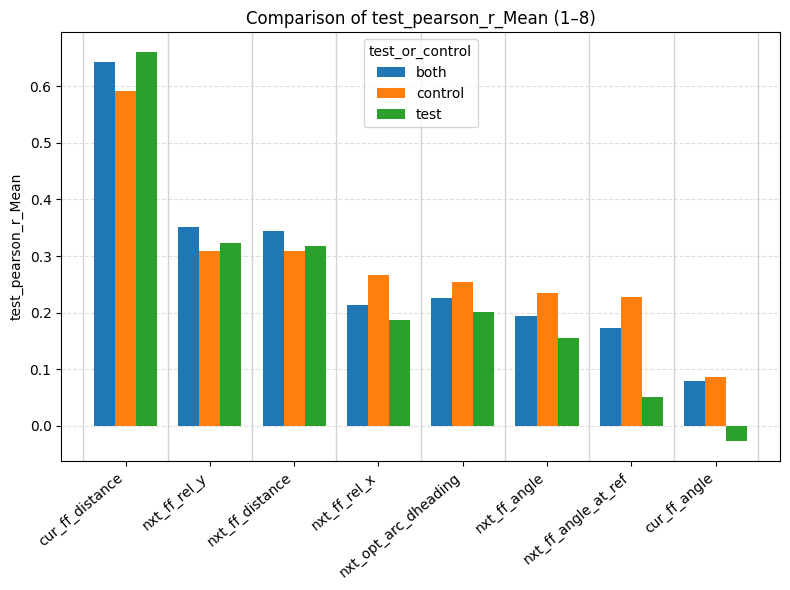

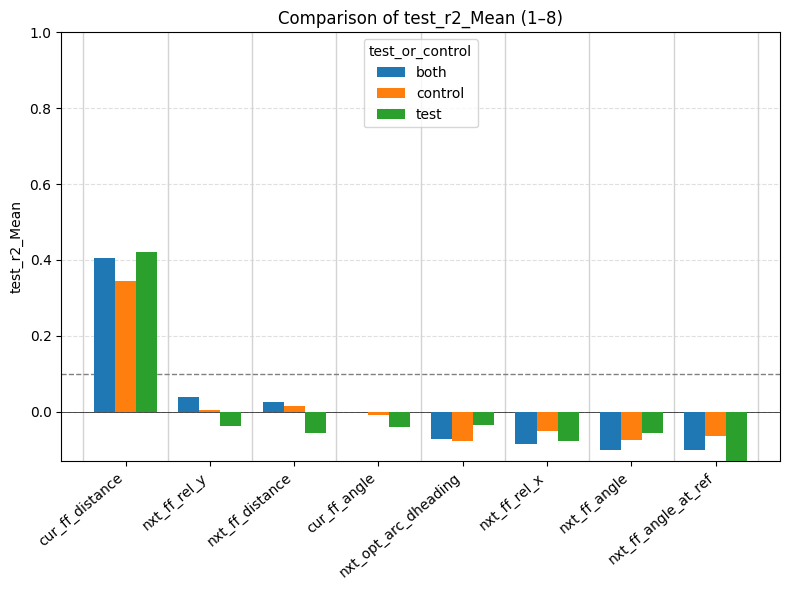

In [22]:
# regression results
for metric in ['test_pearson_r_Mean', 'test_r2_Mean']:
    ml_methods_utils.make_barplot_to_compare_results(
            reg_results, 
            metric=metric, 
        )

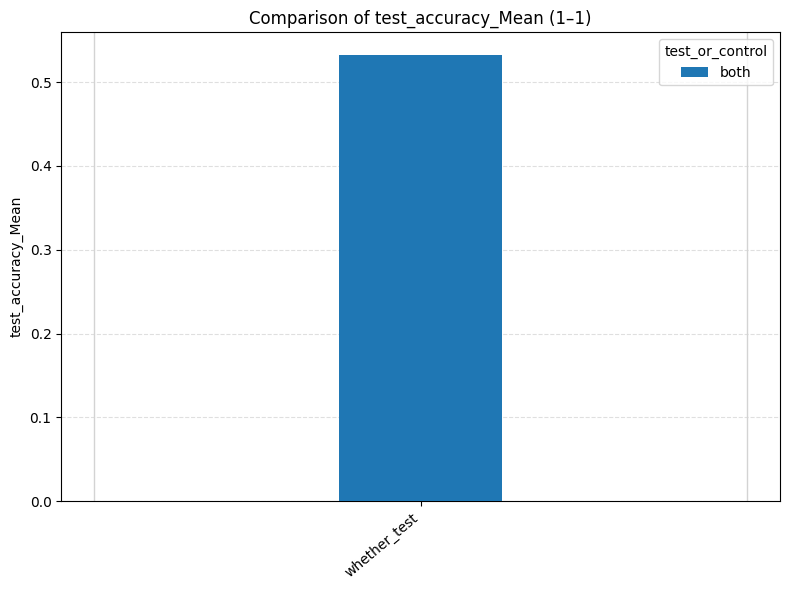

In [23]:
# classification results
for metric in ['test_accuracy_Mean']:
    ml_methods_utils.make_barplot_to_compare_results(
        class_results, 
        metric=metric, 
    )

## segment split regress train-test
Warning: results can be very unstable due to the stochasticity of train-test split

y_var_column: nxt_ff_rel_y

--- Multiple Linear Regression: nxt_ff_rel_y ---
R-squared (train):        0.2351
Adjusted R-squared:       0.2324
R-squared (test):         0.2779
Pearson Corr (test):      0.5356
MAE (test):               87.2465
MSE (test):               12290.0546
RMSE (test):              110.8605


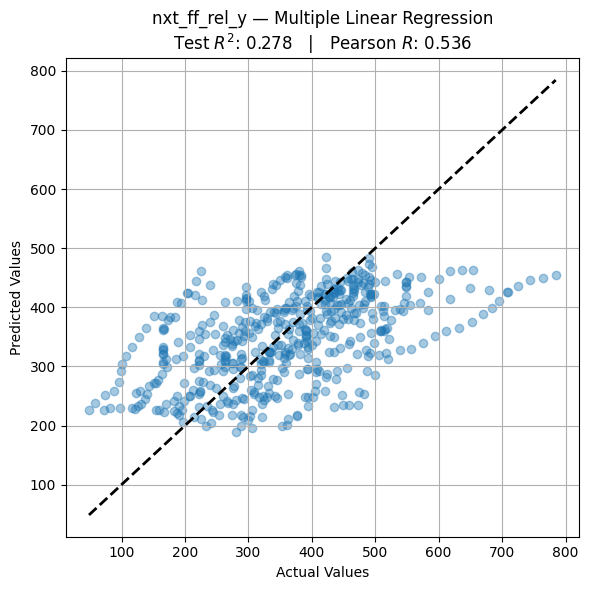

y_var_column: nxt_opt_arc_dheading

--- Multiple Linear Regression: nxt_opt_arc_dheading ---
R-squared (train):        0.0858
Adjusted R-squared:       0.0826
R-squared (test):         0.0701
Pearson Corr (test):      0.2664
MAE (test):               0.3362
MSE (test):               0.2035
RMSE (test):              0.4512


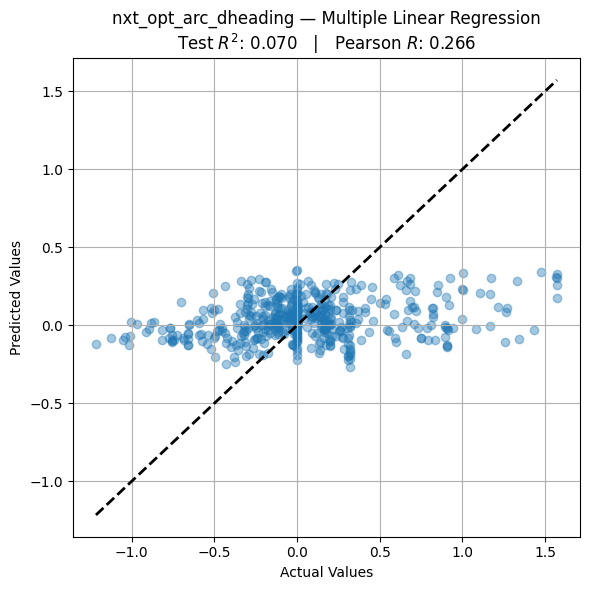

y_var_column: nxt_ff_rel_x

--- Multiple Linear Regression: nxt_ff_rel_x ---
R-squared (train):        0.0760
Adjusted R-squared:       0.0727
R-squared (test):         0.0787
Pearson Corr (test):      0.2903
MAE (test):               74.9639
MSE (test):               11617.4482
RMSE (test):              107.7843


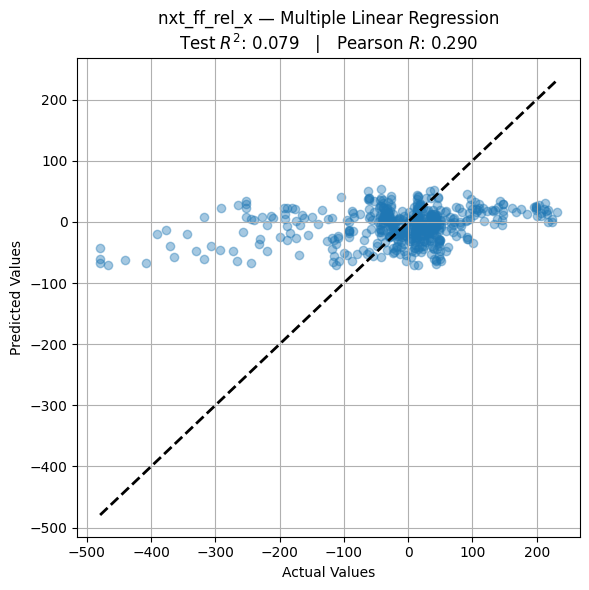

y_var_column: nxt_ff_angle

--- Multiple Linear Regression: nxt_ff_angle ---
R-squared (train):        0.0742
Adjusted R-squared:       0.0710
R-squared (test):         0.0566
Pearson Corr (test):      0.2381
MAE (test):               0.1850
MSE (test):               0.0569
RMSE (test):              0.2385


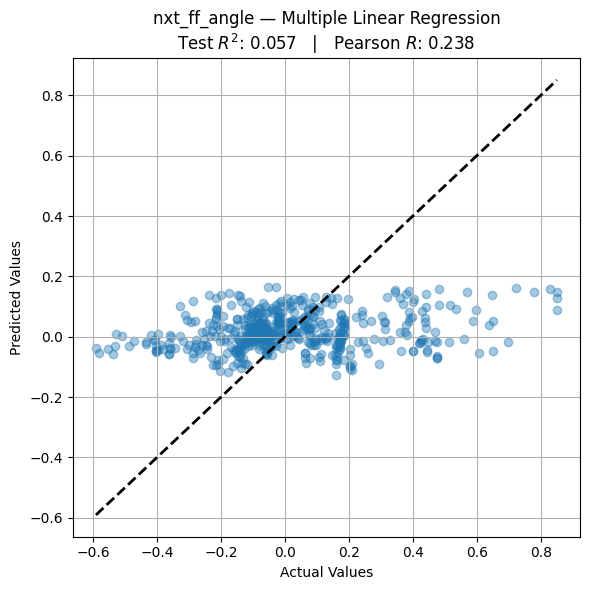

y_var_column: nxt_ff_angle_at_ref

--- Multiple Linear Regression: nxt_ff_angle_at_ref ---
R-squared (train):        0.0404
Adjusted R-squared:       0.0370
R-squared (test):         0.0713
Pearson Corr (test):      0.3185
MAE (test):               0.1986
MSE (test):               0.0686
RMSE (test):              0.2618


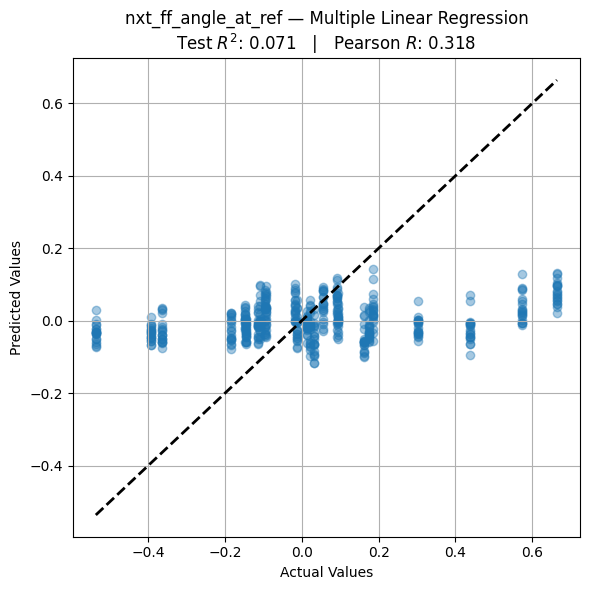

In [24]:
x_var = pn.concat_neural_trials
y_var = pn.concat_behav_trials

columns_of_interest = ['nxt_ff_rel_y', 'nxt_opt_arc_dheading', 'nxt_ff_rel_x', 'nxt_ff_angle', 'nxt_ff_angle_at_ref']
ml_methods_utils.run_segment_split_regression(x_var, y_var, columns_of_interest)

## plot latent dimensions

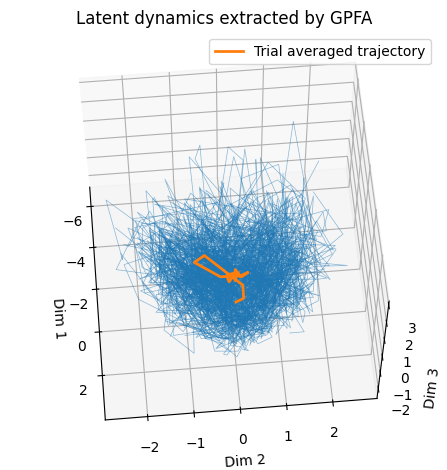

(<Figure size 640x480 with 1 Axes>,
 <Axes3D: title={'center': 'Latent dynamics extracted by GPFA'}, xlabel='Dim 1', ylabel='Dim 2', zlabel='Dim 3'>)

In [25]:
plot_gpfa_utils.plot_gpfa_traj_3d_uniform_color(pn.trajectories)


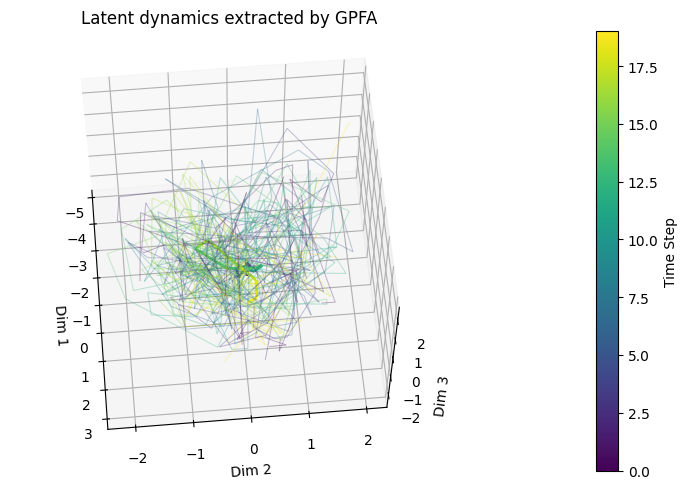

In [26]:
# First, enable interactive mode in your notebook
%matplotlib inline

# Import required modules
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Create the interactive plot
fig, ax = plot_gpfa_utils.plot_gpfa_traj_3d(
    trajectories=pn.trajectories,
    figsize=(15, 5),
    linewidth_single_trial=0.75,
    alpha_single_trial=0.3,
    linewidth_trial_average=2,
    title='Latent dynamics extracted by GPFA',
    view_azim=-5,
    view_elev=60
)

plt.show()

In [27]:
# fig = plot_gpfa_utils.plot_gpfa_traj_3d_plotly(trajectories)

In [28]:
# Find variance explained by each latent dimension
traj_stack = np.stack(pn.trajectories, axis=0)  # shape: (n_trials, 3, T)
var_by_dim = np.var(traj_stack, axis=(0, 2))    # variance across trials and time
var_by_dim /= var_by_dim.sum()               # normalize to get explained variance ratio
print("Variance explained by each latent dimension:", var_by_dim)


Variance explained by each latent dimension: [0.48784 0.16772 0.16707 0.108   0.06937]


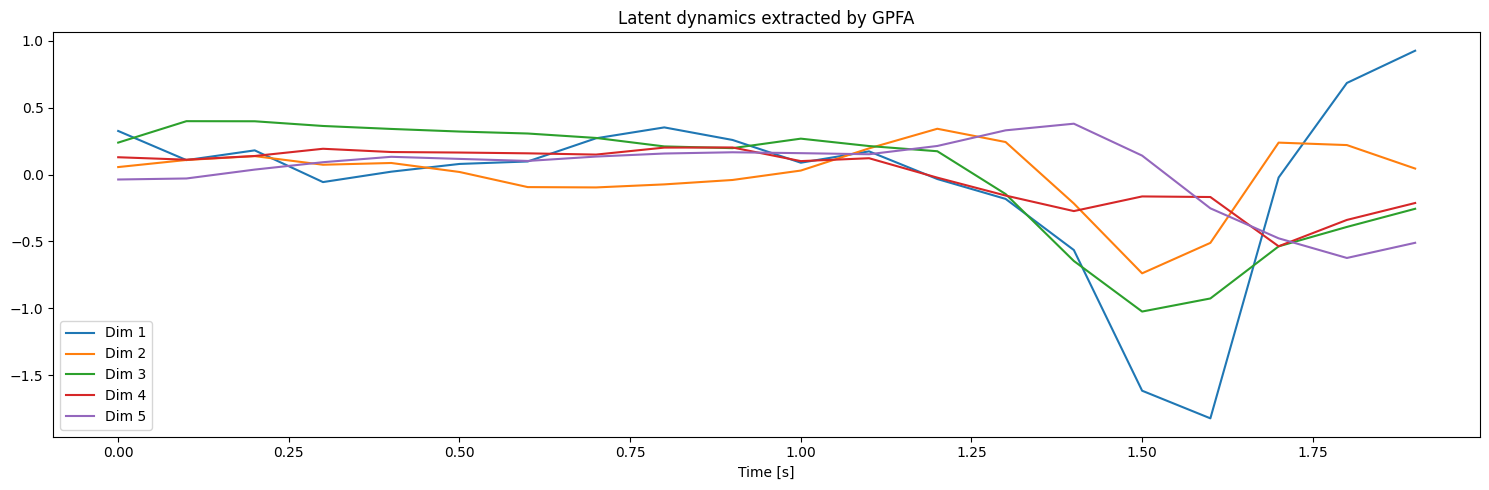

In [29]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Latent dynamics extracted by GPFA')
ax.set_xlabel('Time [s]')

average_trajectory = np.mean(pn.trajectories, axis=0)
time = np.arange(len(average_trajectory[0])) * pn.bin_width  # assuming all trajectories have the same length

for i, x in enumerate(average_trajectory):
    ax.plot(time, x, label=f'Dim {i+1}')

ax.legend()

plt.tight_layout()
plt.show()


## why poor performance?

In [ ]:
import neural_data_analysis.neural_analysis_tools.gpfa_methods.time_resolved_regression as time_resolved_regression

# 1. Print number of trials per timepoint
time_resolved_regression.print_trials_per_timepoint(pn.gpfa_neural_trials)

# 2. Check for NaNs
time_resolved_regression.check_for_nans_in_trials(pn.gpfa_neural_trials, name='latent')
time_resolved_regression.check_for_nans_in_trials(pn.behav_trials, name='behavioral')

# 3. Standardize trials
latent_trials_std = time_resolved_regression.standardize_trials(pn.gpfa_neural_trials)
behav_trials_std = time_resolved_regression.standardize_trials(pn.behav_trials)

# 4. Plot latent and behavioral variables for a few trials
time_resolved_regression.plot_latents_and_behav_trials(latent_trials_std, behav_trials_std, pn.bin_width, n_trials=5)


AttributeError: module 'neural_data_analysis.neural_analysis_tools.gpfa_methods.gpfa_time_resolved_regression' has no attribute 'print_trials_per_timepoint'

## hyperparams (still need to debug)

In [ ]:
stop! # this section is not finished yet

# grid search

import itertools
from joblib import Parallel, delayed, cpu_count
print(f"Detected CPU cores: {cpu_count()}")

# # can add for smoothing:
# # other forms of smoothing like (currently it's only uniform_filter1d)
# from scipy.ndimage import gaussian_filter1d
# # gpfa_neural_trials: list of trials, each trial shape (time_bins, n_neurons)
# smoothed_trials = [
#     gaussian_filter1d(trial, sigma=smooth_sigma, axis=0)
#     for trial in gpfa_neural_trials
# ]


# Define your grid
smoothing_windows = [1, 3]
use_sqrt = [True, False]
gpfa_dims = [3, 5]
bin_widths = [0.02]
ridge_alphas = [0.1, 1]
regression_types = ['ridge']
align_at_beginning_opts = [True]
pca_components = [5, 10]

param_grid_gpfa = list(itertools.product(
    smoothing_windows, use_sqrt, gpfa_dims, bin_widths, ridge_alphas, regression_types, align_at_beginning_opts
))

# Baseline configs
param_grid_raw = list(itertools.product(
    smoothing_windows, use_sqrt, bin_widths, ridge_alphas, regression_types, align_at_beginning_opts
))
param_grid_pca = list(itertools.product(
    smoothing_windows, use_sqrt, bin_widths, ridge_alphas, regression_types, align_at_beginning_opts, pca_components
))

# Run GPFA grid
results_gpfa = Parallel(n_jobs=-1, verbose=10)(
    delayed(gpfa_tuning.run_gpfa_experiment_time_resolved)(
        dec, smoothing, sqrt, gpfa_dim, bin_width, ridge_alpha, regression_type, align_at_beginning, baseline=None
    )
    for (smoothing, sqrt, gpfa_dim, bin_width, ridge_alpha, regression_type, align_at_beginning) in param_grid_gpfa
)

# Run raw baseline grid
results_raw = Parallel(n_jobs=-1, verbose=10)(
    delayed(gpfa_tuning.run_gpfa_experiment_time_resolved)(
        dec, smoothing, sqrt, None, bin_width, ridge_alpha, regression_type, align_at_beginning, baseline='raw'
    )
    for (smoothing, sqrt, bin_width, ridge_alpha, regression_type, align_at_beginning) in param_grid_raw
)

# Run PCA baseline grid
results_pca = Parallel(n_jobs=-1, verbose=10)(
    delayed(gpfa_tuning.run_gpfa_experiment_time_resolved)(
        dec, smoothing, sqrt, None, bin_width, ridge_alpha, regression_type, align_at_beginning, baseline='pca', pca_components=pca_comp
    )
    for (smoothing, sqrt, bin_width, ridge_alpha, regression_type, align_at_beginning, pca_comp) in param_grid_pca
)

# Combine all results
results_summary = results_gpfa + results_raw + results_pca
df = pd.DataFrame(results_summary)
print(df.sort_values('mean_r2', ascending=False).head(10))

In [ ]:
import matplotlib.pyplot as plt
best = df.iloc[df['mean_r2'].idxmax()]
plt.plot(best['times'], np.nanmean(np.array(best['r2_by_time']), axis=1))
plt.xlabel('Time (s)')
plt.ylabel('Mean R²')
plt.title(f"Best config: {best['model']} R² by time")
plt.show()

# Compare models
import seaborn as sns
sns.catplot(data=df, x='model', y='mean_r2', kind='bar')

# ML to decode single vars

## decode

In [ ]:
# neural_data = pn.x_var_lags
# behavioral_data = pn.y_var_reduced

neural_data = pn.concat_neural_trials
behavioral_data = pn.concat_behav_trials

In [ ]:
from neural_data_analysis.neural_analysis_tools.model_neural_data import transform_vars, ml_decoder_class, neural_data_modeling, drop_high_corr_vars, drop_high_vif_vars

In [ ]:
# General usage for any behavioral variable
decoder = ml_decoder_class.MLBehavioralDecoder()
models_to_use=['rf', 'nn', 'lr']
successful_decodings = {}

for var in ['nxt_ff_rel_y', 'nxt_ff_distance']:
    result = decoder.decode_variable(neural_data, behavioral_data, var, models_to_use=models_to_use)
    if result is not None:
        successful_decodings[var] = result

best_model, best_results = decoder.get_best_model('target_rel_y', 'test_r2')

# Plot rf results for any variable
decoder.plot_ml_results('target_rel_y', 'rf')

successful_decodings

## compare different Models

Let's compare the performance of different machine learning models.


In [ ]:
from neural_data_analysis.topic_based_neural_analysis.target_decoder import behav_features_to_keep, target_decoder_class, prep_target_decoder, eval_target_decoder

In [ ]:
comparison_df = eval_target_decoder.compare_models(successful_decodings)

## plot feature importance for RF

In [ ]:
# Analyze feature importance for Random Forest models
for target_var in successful_decodings.keys():
    if 'rf' in successful_decodings[target_var]:
        print(f"\n{'='*50}")
        print(f"FEATURE IMPORTANCE: {target_var}")
        print('='*50)
        
        rf_model = successful_decodings[target_var]['rf']['model']
        
        if hasattr(rf_model, 'feature_importances_'):
            # Get feature importance
            importance_df = regression_utils._get_rf_feature_importances(rf_model, pn.neural_data.columns)
            # Show top 10 most important features
            print(f"Top 10 most important neurons for {target_var}:")
            print(importance_df.head(10))
            
            # Plot feature importance
            regression_utils.plot_feature_importance(importance_df, target_var)


# Save Results (have yet to try)

Finally, let's save our results for future analysis.


In [ ]:
import pickle
import json
import pandas as pd
from typing import Dict, Any

def create_experiment_info(decoder, monkey: str, session: str) -> Dict[str, Any]:
    """Create experiment information dictionary."""
    return {
        'monkey': monkey,
        'session': session,
        'bin_width': decoder.bin_width,
        'neural_data_shape': decoder.neural_data.shape,
        'target_data_shape': decoder.target_data.shape
    }

def create_cca_results(decoder) -> Dict[str, Any]:
    """Create CCA results summary."""
    return {
        'top_3_correlations': (
            decoder.results['cca']['canonical_correlations'][:3].tolist() 
            if 'cca' in decoder.results else None
        )
    }

def find_best_performances(successful_decodings: Dict) -> Dict[str, Dict[str, Any]]:
    """Find best performing model for each target variable."""
    best_performances = {}
    for target_var, models in successful_decodings.items():
        best_model = None
        best_score = -1
        
        for model_name, results in models.items():
            score = results.get('test_r2', results.get('test_accuracy', results.get('cv_mean', 0)))
            if score > best_score:
                best_score = score
                best_model = model_name
        
        best_performances[target_var] = {
            'best_model': best_model,
            'best_score': best_score
        }
    return best_performances

def create_summary_report(decoder, successful_decodings: Dict, monkey: str, session: str) -> Dict[str, Any]:
    """Create complete summary report."""
    return {
        'experiment_info': create_experiment_info(decoder, monkey, session),
        'cca_results': create_cca_results(decoder),
        'ml_results_summary': {
            'successful_targets': list(successful_decodings.keys()),
            'best_performances': find_best_performances(successful_decodings)
        }
    }

def print_summary_report(summary_report: Dict[str, Any]):
    """Print formatted summary report."""
    print("\nEXPERIMENT SUMMARY")
    print("="*50)
    print(f"Neural data shape: {summary_report['experiment_info']['neural_data_shape']}")
    print(f"Target data shape: {summary_report['experiment_info']['target_data_shape']}")
    
    if summary_report['cca_results']['top_3_correlations']:
        print(f"Top 3 CCA correlations: {summary_report['cca_results']['top_3_correlations']}")
    
    print(f"Successfully decoded targets: {summary_report['ml_results_summary']['successful_targets']}")
    
    print("\nBest model performance for each target:")
    for target, perf in summary_report['ml_results_summary']['best_performances'].items():
        print(f"  {target}: {perf['best_model']} (score: {perf['best_score']:.4f})")

def save_experiment_results(decoder, successful_decodings: Dict, monkey: str, session: str, 
                          base_filename: str = None):
    """Save both detailed results and summary report."""
    if base_filename is None:
        base_filename = f"target_decoding_results_{monkey}_{session}"
    
    pkl_filename = f"{base_filename}.pkl"
    json_filename = f"{base_filename}_summary.json"
    
    # Save detailed results
    print("Saving results...")
    decoder.save_results(pkl_filename)
    
    # Create and save summary report
    summary_report = create_summary_report(decoder, successful_decodings, monkey, session)
    print_summary_report(summary_report)
    
    with open(json_filename, 'w') as f:
        json.dump(summary_report, f, indent=2)
    
    print(f"\nResults saved to: {pkl_filename}")
    print(f"Summary saved to: {json_filename}")
    
    return pkl_filename, json_filename

def load_experiment_results(base_filename: str = None, monkey: str = None, session: str = None):
    """Load both detailed results and summary report."""
    if base_filename is None:
        if monkey and session:
            base_filename = f"target_decoding_results_{monkey}_{session}"
        else:
            raise ValueError("Must provide either base_filename or both monkey and session")
    
    pkl_filename = f"{base_filename}.pkl"
    json_filename = f"{base_filename}_summary.json"
    
    try:
        # Load detailed results
        with open(pkl_filename, 'rb') as f:
            decoder_results = pickle.load(f)
        
        # Load summary report
        with open(json_filename, 'r') as f:
            summary_report = json.load(f)
        
        print(f"Loaded results from: {pkl_filename}")
        print(f"Loaded summary from: {json_filename}")
        
        return decoder_results, summary_report
        
    except FileNotFoundError as e:
        print(f"File not found: {e}")
        return None, None
    except Exception as e:
        print(f"Error loading results: {e}")
        return None, None

# --- Usage Examples ---

# Saving (replaces your original code):
# save_experiment_results(decoder, successful_decodings, 'Bruno', 'data_0328')

# Loading:
# decoder_results, summary_report = load_experiment_results(monkey='Bruno', session='data_0328')
# OR
# decoder_results, summary_report = load_experiment_results(base_filename="target_decoding_results_bruno_0328")

# If you want to print the loaded summary:
# if summary_report:
#     print_summary_report(summary_report)

# Appendix

## check NA

In [ ]:
pn.x_var.shape

In [ ]:
general_utils.check_na_in_df(pn.planning_data_by_bin)

In [ ]:
pn.planning_data_by_point.shape

In [ ]:
general_utils.check_na_in_df(pn.planning_data_by_point)

In [ ]:
general_utils.check_na_in_df(pn.ctrl_data_inst.both_ff_across_time_df)

## analyze_trial_lengths

In [ ]:
from neural_data_analysis.neural_analysis_tools.gpfa_methods import fix_gpfa_trial_length
# First, analyze the trial lengths
analysis = fix_gpfa_trial_length.analyze_trial_lengths(pn.spiketrains)
print("Trial length analysis:")
for key, value in analysis.items():
    print(f"  {key}: {value}")